# Inference with a pretrained classifier

In [9]:
import keras_cv
import keras
import numpy as np

classifier = keras_cv.models.ImageClassifier.from_preset(
    "efficientnetv2_b0_imagenet_classifier"
)

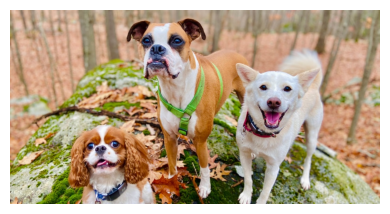

In [10]:
filepath = keras.utils.get_file(origin="https://activedog.org/wp-content/uploads/2022/04/dog5-1030x541.jpg")
image = keras.utils.load_img(filepath)
image = np.array(image)
keras_cv.visualization.plot_image_gallery(
    np.array([image]), rows=1, cols=1, value_range=(0, 255), show=True, scale=4
)

In [11]:
predictions = classifier.predict(np.expand_dims(image, axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [12]:
top_classes = predictions[0].argsort(axis=-1)

In [13]:
import json
import keras.utils

classes = keras.utils.get_file(
    origin="https://gist.githubusercontent.com/LukeWood/62eebcd5c5c4a4d0e0b7845780f76d55/raw/fde63e5e4c09e2fa0a3436680f436bdcb8325aac/ImagenetClassnames.json"
)
with open(classes, "rb") as f:
    classes = json.load(f)

In [14]:
top_two = [classes[str(i)] for i in top_classes[-2:]]
print("Top two classes are:", top_two)

Top two classes are: ['Ibizan hound, Ibizan Podenco', 'Chihuahua']


# Fine-tuning a pretrained backbone

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Convert class vectors to binary class matrices
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

# Split the training data into training and validation sets
val_images = train_images[:5000]
val_labels = train_labels[:5000]
train_images = train_images[5000:]
train_labels = train_labels[5000:]

# Create ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_gen = datagen.flow(train_images, train_labels, batch_size=32)
val_gen = datagen.flow(val_images, val_labels, batch_size=32)
test_gen = datagen.flow(test_images, test_labels, batch_size=32)

# Load MobileNetV2 with ImageNet weights as a base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the base model
base_model.trainable = False

# Create a new model on top
model = Sequential([
    base_model,
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(10, activation='softmax')  # CIFAR-10 has 10 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the top layers
model.fit(train_gen, epochs=2, validation_data=val_gen)

# Unfreeze some layers of the base model for fine-tuning
base_model.trainable = True
fine_tune_at = 100  # This is an example, adjust based on model architecture

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

# Compile the model with a low learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training the model
model.fit(train_gen, epochs=2, validation_data=val_gen)

# Evaluate the model
loss, accuracy = model.evaluate(test_gen)
print("Test Accuracy:", accuracy)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


<ipython-input-4-26b03ac766c8>:34: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/2
   3/1407 ━━━━━━━━━━━━━━━━━━━━ 1:00 43ms/step - accuracy: 0.0851 - loss: 2.3009 

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 78s 51ms/step - accuracy: 0.1132 - loss: 2.2992 - val_accuracy: 0.1418 - val_loss: 2.2540
Epoch 2/2
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 71s 51ms/step - accuracy: 0.1502 - loss: 2.2419 - val_accuracy: 0.1658 - val_loss: 2.2030
Epoch 1/2
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 201s 130ms/step - accuracy: 0.1332 - loss: 3.5529 - val_accuracy: 0.0966 - val_loss: 4.0980
Epoch 2/2
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 199s 128ms/step - accuracy: 0.1846 - loss: 2.3378 - val_accuracy: 0.1100 - val_loss: 2.3386
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.1099 - loss: 2.3429
Test Accuracy: 0.11100000143051147


# Training a image classifier from scratch

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_and_preprocess_data():
    # Load and preprocess your data
    # Replace this with your own data loading and preprocessing logic
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
    train_images, test_images = train_images / 255.0, test_images / 255.0
    return (train_images, train_labels), (test_images, test_labels)

def create_model(input_shape, num_classes):
    # Define your model
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes)  # Assuming 10 classes
    ])
    return model

def compile_and_train_model(model, train_data, test_data, epochs):
    # Compile the model
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(train_data[0], train_data[1], epochs=epochs,
                        validation_data=test_data)

    return history

def evaluate_model(model, test_data):
    # Evaluate the model
    test_loss, test_acc = model.evaluate(test_data[0], test_data[1], verbose=2)
    print(f"Test Accuracy: {test_acc}")

if __name__ == "__main__":
    # Load and preprocess data
    train_data, test_data = load_and_preprocess_data()

    # Define model
    input_shape = train_data[0].shape[1:]
    num_classes = 10
    model = create_model(input_shape, num_classes)

    # Compile and train model
    epochs = 10
    history = compile_and_train_model(model, train_data, test_data, epochs)

    # Evaluate model
    evaluate_model(model, test_data)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 74s 45ms/step - accuracy: 0.3495 - loss: 1.7484 - val_accuracy: 0.5284 - val_loss: 1.2966
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 66s 43ms/step - accuracy: 0.5699 - loss: 1.2045 - val_accuracy: 0.6205 - val_loss: 1.0721
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 42ms/step - accuracy: 0.6408 - loss: 1.0255 - val_accuracy: 0.6231 - val_loss: 1.0778
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 68s 44ms/step - accuracy: 0.6808 - loss: 0.9122 - val_accuracy: 0.6729 - val_loss: 0.9189
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - accuracy: 0.7082 - loss: 0.8297 - val_accuracy: 0.6769 - val_loss: 0.9187
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 65s 42ms/step - accuracy: 0.7282 - loss: 0.7790 - val_accuracy: 0.6754 - val_loss: 0.9499
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 68s 43ms/step - accuracy: 0.7468 - loss: 0.7120 - val_accuracy: 0.7097 - val_loss: 0.8495
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 79s 42ms/step - accuracy: 0.7595 -